<a href="https://colab.research.google.com/github/Musbell/Planta---Maize-disease-symptoms-detection/blob/master/Planta_Maize_disease_symptoms_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Wed Feb 26 07:14:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-tmz62mp0
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-tmz62mp0
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275363 sha256=65d644b0022b75c5d2b07d075db79331e68ce6c97e12b534c75daf996e2db56c
  Stored in directory: /tmp/pip-ephem-wheel-cache-m_ohf4t7/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [0]:
!pip install onnx
!pip install mock

In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

CPython 3.6.9
IPython 5.5.0

numpy 1.17.5
pandas 0.25.3
pycocotools 2.0
torch 1.4.0+cu100
torchvision 0.5.0+cu100
detectron2 0.1.1+cu100


In [0]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import onnx
from unittest.mock import MagicMock

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

torch.__version__
!gcc --version 

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [0]:
# Download annotaions.json file from google drive
!gdown --id 1H6cuE8SyEgmoINxglMfeCAIgQUW3nOTj
# Download dataset file from google drive
!gdown --id 1XkG4aYIjSPlBMv0NxIyGD22VDVeh-pnn

In [0]:
# Extract compressed dataset to My Drive
!tar -xf '/content/images_handheld.tar.gz' --directory '/content/drive/My Drive/Plant disease detection project'

In [0]:
dataset_dir = '/content/drive/My Drive/Plant disease detection project/images_handheld'

In [0]:
diseases_df = pd.read_json('/content/drive/My Drive/Plant disease detection project/annotations.json')

In [0]:
diseases_df.head()

,image,x1,y1,x2,y2
0,DSC00025.JPG,1864,2064,2864,1648
1,DSC00026.JPG,2872,1416,3152,2016
2,DSC00027.JPG,0,0,0,0
3,DSC00028.JPG,3248,1540,3572,2048
4,DSC00028.JPG,3444,1916,3852,2116


In [0]:
dataset = []


for index, row in tqdm(diseases_df.iterrows(), total=diseases_df.shape[0]):

    data = {}


    image_name = row['image']

    im = Image.open('{}/{}'.format(dataset_dir, image_name))

    w, h = im.size

    data['file_name'] = image_name
    data['height'] = h
    data['width'] = w
    data["x_min"] = row["x1"]
    data["y_min"] = row["y1"]
    data["x_max"] = row["x2"]
    data["y_max"] = row["y2"]

    data['class_name'] = 'Northern Leaf Blight'

    dataset.append(data)

In [0]:
df = pd.DataFrame(dataset)
df.head()

In [0]:
print(df.file_name.unique().shape[0], df.shape[0])

In [0]:
def annotate_image(annotations):
  file_name = annotations.file_name.to_numpy()[0]
  img = cv2.cvtColor(cv2.imread(f'{dataset_dir}/{file_name}'), cv2.COLOR_BGR2RGB)

  for i, a in annotations.iterrows():    
    cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 8)

    return img
  # if not resize:
  #   return img

  # return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

In [0]:
img_df = df[df.file_name == df.file_name.unique()[0]]
img = annotate_image(img_df)

plt.imshow(img)
plt.axis('off');

In [0]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

In [0]:
sample_images.shape

In [0]:
sample_images = sample_images.permute(0, 3, 1, 2)
sample_images.shape

In [0]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

**Maize disease symptoms detection with Detectron2**

In [0]:
df.to_csv(f'{dataset_dir}/annotations.csv', header=True, index=None)

NameError: ignored

In [0]:
df = pd.read_csv(f'{dataset_dir}/annotations.csv')


IMAGES_PATH = f'{dataset_dir}'

unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.80), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

,file_name,height,width,x_min,y_min,x_max,y_max,class_name
0,DSC00025.JPG,4000,6000,1864,2064,2864,1648,Northern Leaf Blight
2,DSC00027.JPG,4000,6000,0,0,0,0,Northern Leaf Blight
3,DSC00028.JPG,4000,6000,3248,1540,3572,2048,Northern Leaf Blight
4,DSC00028.JPG,4000,6000,3444,1916,3852,2116,Northern Leaf Blight
5,DSC00029.JPG,4000,6000,0,0,0,0,Northern Leaf Blight


In [0]:
classes = df.class_name.unique().tolist()
print(classes)

['Northern Leaf Blight']


In [0]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}
    

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'

    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [0]:
for d in ["train", "val"]:
  DatasetCatalog.register("diseases_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("diseases_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("diseases_train")

In [0]:
class CocoTrainer(DefaultTrainer):
  
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("/content/drive/My Drive/Plant disease detection project/coco_eval", exist_ok=True)
        output_folder = "/content/drive/My Drive/Plant disease detection project/coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [0]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [0]:
cfg.DATASETS.TRAIN = ("diseases_train",)
cfg.DATASETS.TEST = ("diseases_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.OUTPUT_DIR = '/content/drive/My Drive/Plant disease detection project/output'

In [0]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [0]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

In [0]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train()

[02/26 07:37:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Plant disease detection project/output'

UsageError: Line magic function `%tensorboard` not found.


In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/My Drive/Plant disease detection project/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
print(cfg.MODEL.WEIGHTS)

/content/drive/My Drive/Plant disease detection project/output/model_final.pth


In [0]:
cfg.dump()

In [0]:
evaluator = COCOEvaluator("diseases_val", cfg, False, output_dir="/content/drive/My Drive/Plant disease detection project/output")
val_loader = build_detection_test_loader(cfg, "diseases_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[02/25 18:12:54 d2.evaluation.evaluator]: Start inference on 358 images


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


[02/25 18:15:17 d2.evaluation.evaluator]: Inference done 11/358. 1.0089 s / img. ETA=0:56:04
[02/25 18:15:26 d2.evaluation.evaluator]: Inference done 12/358. 1.0092 s / img. ETA=0:55:48
[02/25 18:15:36 d2.evaluation.evaluator]: Inference done 13/358. 1.0086 s / img. ETA=0:55:41
[02/25 18:15:46 d2.evaluation.evaluator]: Inference done 14/358. 1.0084 s / img. ETA=0:55:30
[02/25 18:15:55 d2.evaluation.evaluator]: Inference done 15/358. 1.0072 s / img. ETA=0:55:15
[02/25 18:16:05 d2.evaluation.evaluator]: Inference done 16/358. 1.0090 s / img. ETA=0:55:05
[02/25 18:16:15 d2.evaluation.evaluator]: Inference done 17/358. 1.0111 s / img. ETA=0:54:52
[02/25 18:16:24 d2.evaluation.evaluator]: Inference done 18/358. 1.0097 s / img. ETA=0:54:39
[02/25 18:16:34 d2.evaluation.evaluator]: Inference done 19/358. 1.0104 s / img. ETA=0:54:25
[02/25 18:16:43 d2.evaluation.evaluator]: Inference done 20/358. 1.0112 s / img. ETA=0:54:20
[02/25 18:16:53 d2.evaluation.evaluator]: Inference done 21/358. 1.011

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 282 had too many entries: 2, expected 1
  % (tag, len(values))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:603: UserWarning: Metadata Warning, tag 283 had too many entries: 2, expected 1
  % (tag, len(values))


[02/25 18:21:02 d2.evaluation.evaluator]: Inference done 47/358. 1.0103 s / img. ETA=0:49:47
[02/25 18:21:12 d2.evaluation.evaluator]: Inference done 48/358. 1.0106 s / img. ETA=0:49:38
[02/25 18:21:22 d2.evaluation.evaluator]: Inference done 49/358. 1.0104 s / img. ETA=0:49:30
[02/25 18:21:31 d2.evaluation.evaluator]: Inference done 50/358. 1.0100 s / img. ETA=0:49:21
[02/25 18:21:41 d2.evaluation.evaluator]: Inference done 51/358. 1.0105 s / img. ETA=0:49:12
[02/25 18:21:51 d2.evaluation.evaluator]: Inference done 52/358. 1.0104 s / img. ETA=0:49:04
[02/25 18:22:01 d2.evaluation.evaluator]: Inference done 53/358. 1.0107 s / img. ETA=0:48:55
[02/25 18:22:10 d2.evaluation.evaluator]: Inference done 54/358. 1.0104 s / img. ETA=0:48:46
[02/25 18:22:20 d2.evaluation.evaluator]: Inference done 55/358. 1.0108 s / img. ETA=0:48:36
[02/25 18:22:29 d2.evaluation.evaluator]: Inference done 56/358. 1.0104 s / img. ETA=0:48:25
[02/25 18:22:39 d2.evaluation.evaluator]: Inference done 57/358. 1.010

OrderedDict([('bbox',
              {'AP': 0.00011369458175201943,
               'AP50': 0.0004494831505622473,
               'AP75': 0.0,
               'APl': 0.00011572780799243346,
               'APm': 0.0,
               'APs': 0.0}),
             ('segm',
              {'AP': 9.5624783648927e-06,
               'AP50': 9.562478364892699e-05,
               'AP75': 0.0,
               'APl': 1.0874234046139375e-05,
               'APm': 0.0,
               'APs': 0.0})])

Find Diseases in the Images

In [0]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [0]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1.2, 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  instances.
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

In [0]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

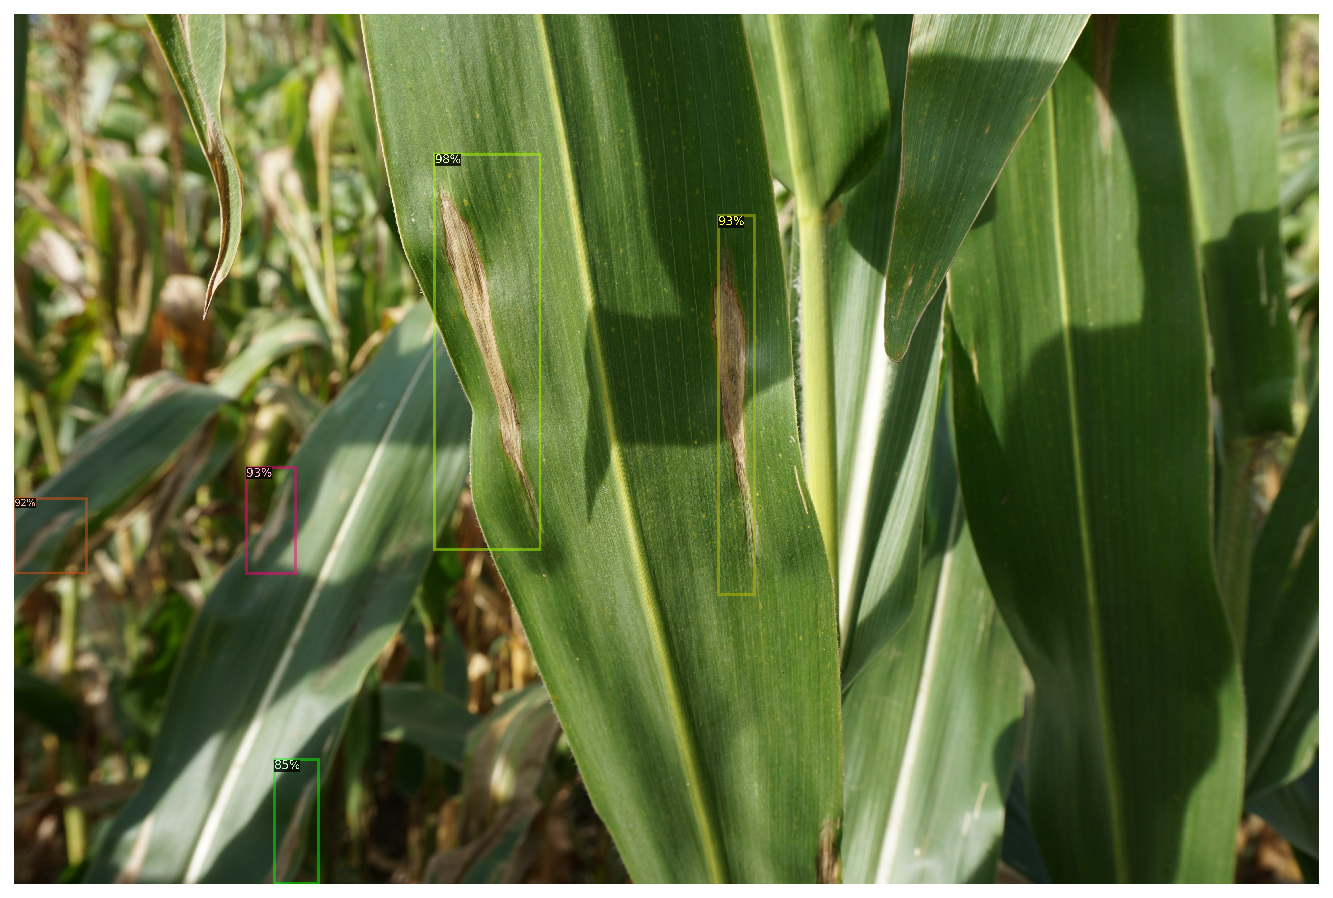

In [0]:
img = cv2.cvtColor(cv2.imread(annotated_images[230]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

Deployment

In [0]:
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.export import add_export_config, export_caffe2_model
from detectron2.modeling import build_model



# create a torch model
torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data
data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))

# convert and save caffe2 model
caffe2_model = export_caffe2_model(cfg, torch_model, first_batch)
caffe2_model.save_protobuf('./caffe2_model')
# draw the caffe2 graph
caffe2_model.save_graph(os.path.join('./caffe2_model', "model.svg"), inputs=first_batch)

# run evaluation with the converted model
if args.run_eval:
    dataset = cfg.DATASETS.TEST[0]
    data_loader = build_detection_test_loader(cfg, dataset)
    # NOTE: hard-coded evaluator. change to the evaluator for your dataset
    evaluator = COCOEvaluator(dataset, cfg, True, './caffe2_model')
    metrics = inference_on_dataset(caffe2_model, data_loader, evaluator)
    print_csv_format(metrics)